<a href="https://colab.research.google.com/github/vircsinger625/Onlab_2020_2/blob/main/%C3%96nlab_3Kutya_StanfordDogsDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [ ]:
!pip install torch
!pip install torchvision

In [3]:
## A szükséges importálások elvégzése

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import itertools
import time

import os, sys
import cv2
from PIL import Image

from torch.autograd import Variable

from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# A képek megjelenítéséhez szükséges függyvény

def imshow(img):  #:param img: (PyTorch Tensor)
    img = img / 2 + 0.5                           # unnormalize
    npimg = img.numpy()                           # Convert tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    # Color channel first -> color channel last
    plt.show()

In [6]:
#Új mappa létrehozása az adatok lementéséhez

%cd /home 
!ls
!mkdir -p StanfordDogsDataset
%cd /home/StanfordDogsDataset

/home/StanfordDogsDataset


In [ ]:
## Az adatbázis letöltése linux serverre a wget linux command segítségével, ha még nem létezik az adott file
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/train_data.mat -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/test_data.mat -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/lists.tar -P /home/StanfordDogsDataset/
!wget -nc http://vision.stanford.edu/aditya86/ImageNetDogs/README.txt -P /home/StanfordDogsDataset/

In [ ]:
## tar fájlok kibontása

!tar -xvf images.tar 
!tar -xvf annotation.tar 
!tar -xvf lists.tar

!ls

In [24]:
num_workers = 2
batch_size= 100
test_batch_size = 4

Képek beolvasása

In [25]:
## Az összes kép betöltése

imgs_dir = '/home/StanfordDogsDataset/Images'
imagenet_data = torchvision.datasets.ImageFolder(imgs_dir)
total_images_num = len(imagenet_data)

In [26]:
## A tanító, teszetelő és validációs adathalmazok szerinti adatbetöltés

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_data, test_data, val_data = torch.utils.data.random_split(imagenet_data, [16464, 2058, 2058], generator=torch.Generator().manual_seed(42))

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                        batch_size = batch_size,
                                        shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)


val_gen = torch.utils.data.DataLoader(dataset = val_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

In [27]:
all_data = len(train_data)+len(test_data)+len(val_data)
total_images_num = len(imagenet_data)
classes = os.listdir(imgs_dir)
num_classes = len(classes)

print(all_data == total_images_num)

print('Classes: %d' % (num_classes))
print("Images number: %d" % (total_images_num))

print('Train Data: \t %.3f%%' %torch.true_divide(100*len(train_data),all_data), '\t Number of images: ', len(train_data))
print('Test  Data: \t %.3f%%' %torch.true_divide(100*len(test_data),all_data), '\t Number of images:  ', len(test_data))
print('Valid Data: \t %.3f%%' %torch.true_divide(100*len(val_data),all_data), '\t Number of images:  ', len(val_data))

True
Classes: 120
Images number: 20580
Train Data: 	 80.000% 	 Number of images:  16464
Test  Data: 	 10.000% 	 Number of images:   2058
Valid Data: 	 10.000% 	 Number of images:   2058


Adatok az adatbázisról és képek kirajzolása 

In [28]:
%cd /home/StanfordDogsDataset

/home/StanfordDogsDataset


In [29]:
#https://www.kaggle.com/msripooja/dog-images-classification-using-keras-alexnet

def load_images_and_labels(classes):
    img_lst=[]
    labels=[]
    for index, category in enumerate(classes):
        for image_name in os.listdir(imgs_dir+"/"+category ):
            img = cv2.imread(imgs_dir+"/"+category +"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_array = Image.fromarray(img, 'RGB')
            
            #resize image to 227 x 227 because the input image resolution for AlexNet is 227 x 227
            resized_img = img_array.resize((227, 227))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(classes)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  20580 
No. of labels loaded =  20580
<class 'list'> <class 'list'>


In [30]:
images = np.array(images)
labels = np.array(labels)
print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (20580, 227, 227, 3) 
Labels shape =  (20580,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


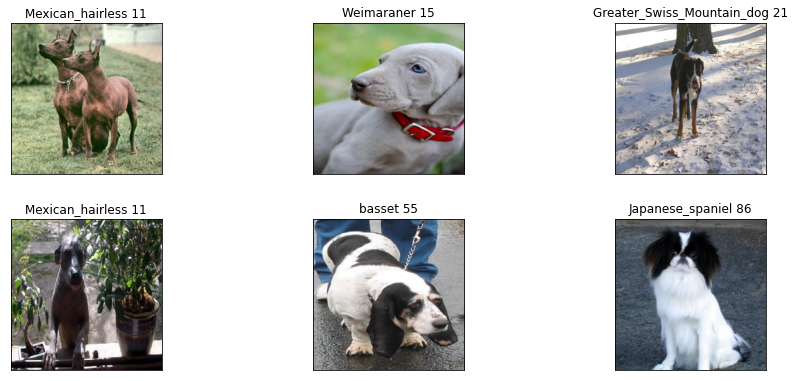

In [31]:
disImgs = 6
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (15 , 10))
    n = 0 
    for i in range(disImgs):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('{} {}'.format(classes[labels[r[0]]][10:], labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

In [ ]:
## Az összes kutyafajta kilistázása (osztályok)

for i in range(0, num_classes): 
  print(i, classes[i][10:])